In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# train_df = pd.read_csv('/content/drive/MyDrive/web_traffic_train_1.csv').fillna(0)
train_df = pd.read_csv('../data/web_traffic_train_1.csv').fillna(0)
train_df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         0.0         0.0   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         0.0  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

# Data pre-processing

In [2]:
import re
def get_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'na'

languages = {'en':'English','ja':'Japanese','de':'German','na':'Media','fr':'French','zh':'Chinese',
             'ru':'Russian','es':'Spanish'}

train_df['lang'] = train_df.Page.map(get_language)

lang_sets = {}
avgs = {}

for lang in languages.keys():
    lang_sets[lang] = train_df[train_df.lang==lang].iloc[:,0:-1]
    avgs[lang] = lang_sets[lang].iloc[:,1:].sum(axis=0)/lang_sets[lang].shape[0]
    
train_df = train_df.drop('lang',axis=1)

In [3]:
top_pages = {}
for key in ['en']:#lang_sets:
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    top_pages[key] = sum_set.index[0:20000]
    top_pages[key] = train_df.iloc[list(top_pages[key]),:]

# Date partitioning

In [4]:
data_start_date = train_df.columns[1]
data_end_date = train_df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


In [5]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [6]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [7]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


In [8]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in train_df.columns[1:]]),
                          data=[i for i in range(len(train_df.columns[1:]))])

def get_time_block_series(df, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return df[:,inds]

def transform_series_encode(df):
    
    df = np.log1p(np.nan_to_num(df)) # filling NaN with 0
    mean = df.mean(axis=1).reshape(-1,1) 
    df = df - mean
    df = df.reshape((df.shape[0],df.shape[1], 1))
    
    return df, mean

def transform_series_decode(df, mean):
    
    df = np.log1p(np.nan_to_num(df)) # filling NaN with 0
    df = df - mean
    df = df.reshape((df.shape[0],df.shape[1], 1))
    
    return df

from math import log1p
def log_transform(df):
    df = list(np.reshape(df,(len(df),)))
    df = np.array([log1p(x) for x in df])
    mean = df.mean()
    df = df - mean
    return df,mean
def inverse_log_transform(df,mean):
    df = np.reshape(df,(len(df),))
    df = df + mean
    df = np.exp(df) - 1
    return df

# Build Model

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [10]:
lstm_units = 50

encoder_inputs = Input(shape=(None, 1))
encoder = LSTM(units = lstm_units, dropout=0.2, return_state=True)
encoder_outputs,final_encoder_state_h,final_encoder_state_c = encoder(encoder_inputs)

final_encoder_state = [final_encoder_state_h,final_encoder_state_c]

decoder_inputs = Input(shape=(None,1))

decoder = LSTM(units = lstm_units, dropout = 0.2, return_sequences=True, return_state=True)
decoder_outputs, final_decoder_state_h,final_decoder_state_c = decoder(decoder_inputs, initial_state=final_encoder_state)

dense = Dense(1)
decoder_outputs = dense(decoder_outputs)

model = Model([encoder_inputs,decoder_inputs],decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 50), (None,  10400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 50), ( 10400       input_2[0][0]                    
                                                                 lstm_1[0][1]               

# Training data

In [11]:
df = train_df[train_df.columns[1:]].values

In [12]:
# n_samples = 40000

# encoder_input_data = get_time_block_series(df,date_to_index,train_enc_start,train_enc_end)[:n_samples]
# encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# decoder_target_data = get_time_block_series(df, date_to_index, train_pred_start, train_pred_end)[:n_samples]
# decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# decoder_input_data = np.zeros(decoder_target_data.shape)
# decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
# decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

In [13]:
# model.compile(Adam(), loss='mean_absolute_error')
# history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#                      batch_size=2**11,
#                      epochs=100,
#                      validation_split=0.2)

In [14]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.xlabel('Epoch')
# plt.ylabel('Mean Absolute Error Loss')
# plt.title('Loss Over Time')
# plt.legend(['Train','Valid'])

In [15]:
model.load_weights('../weights/seq2seq_lstm_weights.h5')

In [16]:
encoder_model = Model(encoder_inputs,final_encoder_state)

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - fill decoded_seq with predictions

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [17]:
# df = train_df[train_df.columns[1:]].values

In [18]:
encoder_input_data = get_time_block_series(df, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(df, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_mean)

In [19]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series)
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series)
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

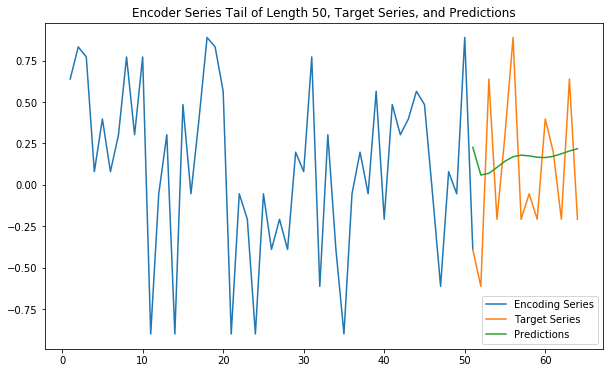

In [20]:
predict_and_plot(encoder_input_data, decoder_target_data, 100)

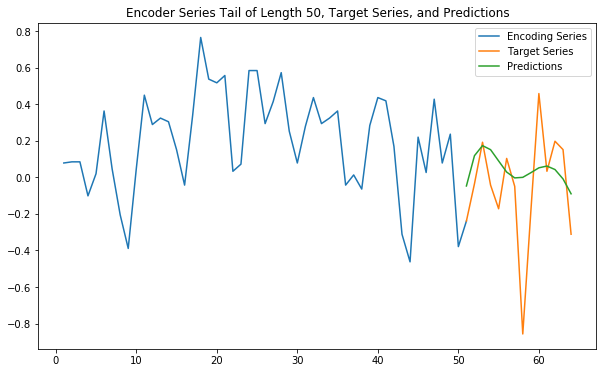

In [21]:
predict_and_plot(encoder_input_data, decoder_target_data, 6007)

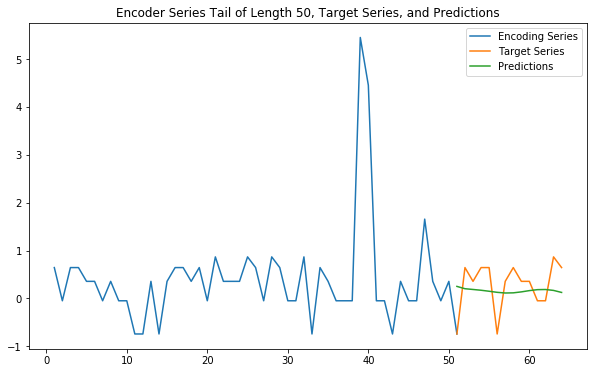

In [22]:
predict_and_plot(encoder_input_data, decoder_target_data, 33000)

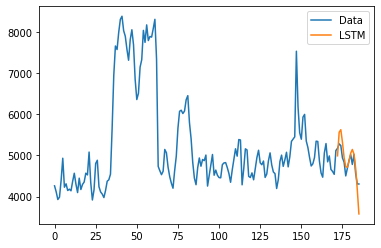

RMSE value:  287.84756689481617


In [23]:
test_sequence = list(avgs['en'])
test_sequence, mean = log_transform(test_sequence)

X = test_sequence[:522]
y = test_sequence[522:536]

y_pred = decode_sequence(np.reshape(X,(1,522,1)))
y_pred = y_pred.reshape((14,))

y = inverse_log_transform(y,mean)
y_pred = inverse_log_transform(y_pred,mean)

plt.plot(list(avgs['en'])[350:522]+list(y),label='Data')
plt.plot(range(172,186),list(y_pred),label='LSTM')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y,y_pred,squared=False)
print('RMSE value: ',rms)